In [141]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures

In [215]:
model = keras.Sequential(
    [
        keras.Input(shape=(784,)),
        layers.Dense(100, activation="sigmoid"),
        layers.Dense(100, activation="sigmoid"),
        RandomFourierFeatures(
            output_dim=4096, scale=10.0, kernel_initializer="gaussian"
        ),
        layers.Dense(units=10),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.hinge,
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
random_fourier_features_3 (R (None, 4096)              413697    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                40970     
Total params: 543,267
Trainable params: 129,570
Non-trainable params: 413,697
_________________________________________________________________


In [216]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data by flattening & scaling it
x_train = x_train.reshape(-1, 784).astype("float32") / 255
x_test = x_test.reshape(-1, 784).astype("float32") / 255

# Categorical (one hot) encoding of the labels
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [217]:
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.1660 - acc: 0.6676 - val_loss: 0.0579 - val_acc: 0.9045
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0532 - acc: 0.9115 - val_loss: 0.0454 - val_acc: 0.9235
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0412 - acc: 0.9310 - val_loss: 0.0362 - val_acc: 0.9407
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0345 - acc: 0.9434 - val_loss: 0.0299 - val_acc: 0.9524
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0302 - acc: 0.9506 - val_loss: 0.0273 - val_acc: 0.9570
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0264 - acc: 0.9582 - val_loss: 0.0280 - val_acc: 0.9575
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0236 - acc: 0.9638 - val_loss: 0.0267 - val_acc: 0.9588
Epoch 8/20
375/375 [==============================] - 1s 3ms/step - loss: 0.

class_label:  0


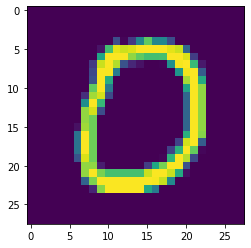

In [218]:
%matplotlib inline
label = y_test[10:11]
print("class_label: ", np.argmax(label))
plt.imshow(np.reshape(x_test[10:11], (28,28)))

In [219]:
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
    # explicitly indicate that our image should be tacked for
    # gradient updates
        tape.watch(input_image)

        y_pred = model(input_image)
        
        print("Input label: ", input_label.shape, "predicted: ", y_pred.shape)
        loss = keras.losses.hinge(input_label, y_pred)
        
    print(loss)
    gradient = tape.gradient(loss, input_image)
    
    temp = gradient.numpy()
    temp[temp<0] = 0
    #print(gradient)
    return temp

In [220]:
image = tf.cast(x_test[10:11], dtype=tf.float32)

original = x_test[10:11]
original_label = y_test[10:11]

new_label = tf.reshape(tf.cast(y_test[30], dtype=tf.float32), (1,10))

print("New label:", np.argmax(new_label), " Original Label:", np.argmax(original_label))

New label: 3  Original Label: 0


Input label:  (1, 10) predicted:  (1, 10)
tf.Tensor([2.0740314], shape=(1,), dtype=float32)
Average perturbation:  0.013991804


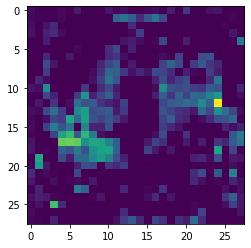

In [221]:
%matplotlib inline
perturbations = create_adversarial_pattern(image, new_label)

temp = tf.reshape(perturbations, (28, 28, 1))
plt.imshow(temp)

print("Average perturbation: ", np.mean(temp))

image = np.reshape(image, (1,784))
perturbations = np.reshape(perturbations, (1,784))

In [222]:
def display_images(image, description):
    label = np.argmax(model.predict(image))
    #confidence = model.predict(image)[0][label]
    
    value = PSNR(original, image.numpy())
    
    temp2 = tf.reshape(image, (28, 28, 1))
    plt.imshow(temp2)
    plt.title('{} \n {} : {:.2f} PSNR'.format(description, label, value))
    plt.show()

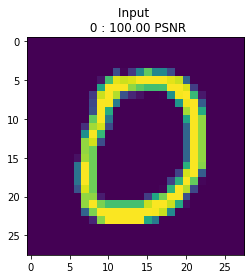

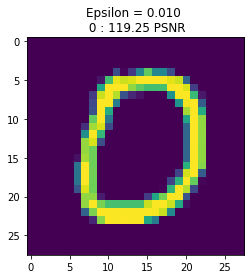

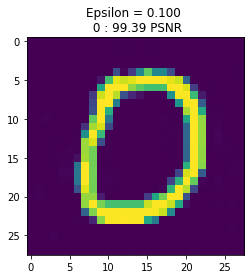

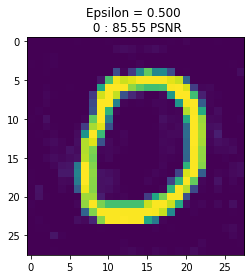

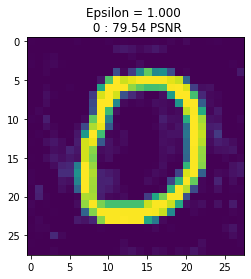

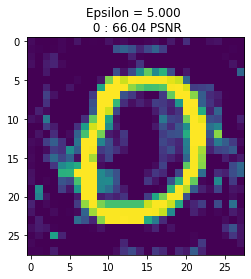

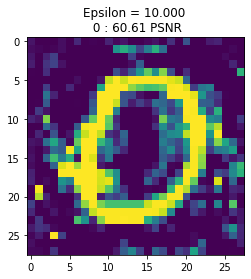

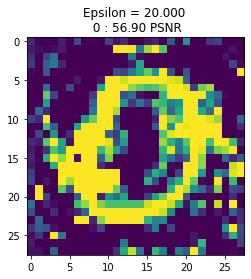

In [224]:
epsilons = [0, 0.01, 0.1, 0.5, 1, 5, 10, 20]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])